## Face Detection in PS

[[195  68 246 246]]


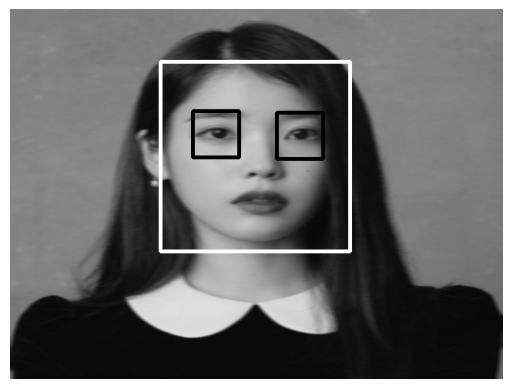

In [ ]:
from pynq import Overlay
overlay = Overlay("./bitstream/Sharpen.bit")

import pynq.lib.dma

dma_send = overlay.axi_dma_from_ps_to_pl
dma_recv = overlay.axi_dma_from_pl_to_ps
#-------------------------------------------------

import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import time

face_flag = True    # use in while loop

# detect faces and eyes
while(face_flag):
    i=0
    
    # image pre-processing
    PL_img = cv2.imread("./image/IU.jpg")
    PL_img = cv2.cvtColor(PL_img, cv2.COLOR_BGR2GRAY)
    PL_img = cv2.resize(PL_img, (640, 480))
    PL_img = cv2.blur(PL_img, (7,1))
    
    pad_for_PL = np.pad(PL_img, ((1,1), (1,1)), mode = 'constant')    # zero padding of image
    
    PS_img = cv2.imread("./image/IU.jpg")
    PS_img = cv2.cvtColor(PS_img, cv2.COLOR_BGR2GRAY)
    PS_img = cv2.resize(PS_img, (640, 480))
    PS_img = cv2.blur(PS_img, (7,1))
    
    img = cv2.imread("./image/IU.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (640, 480))
    img = cv2.blur(img, (7,1))
    # pre-processing finished
    
    # import face data
    faceCascade = cv2.CascadeClassifier('data_face.xml')
    # import eye data
    eyeCascade = cv2.CascadeClassifier('data_eye.xml')

    # detect face
    faces = faceCascade.detectMultiScale(img, 1.1, 3)
    for (x,y,w,h) in faces:
        # draw face rectangle
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0),3)
        roi_gray = img[y:y+h, x:x+w]
        
        # detect eye
        eyes = eyeCascade.detectMultiScale(roi_gray,3,8)
        
        # draw eye rectangle
        for eye in eyes:
            (ex,ey,ew,eh) = eye
            cv2.rectangle(roi_gray, (ex, ey), (ex+ew, ey+eh), (0,255,0), 3)
            i+=1
        # pop out if two eyes are both detected
        if(i>1):
            face_flag = False
            break

plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()

## Software - Sharpen in PS

PS:  0.3825216293334961 s


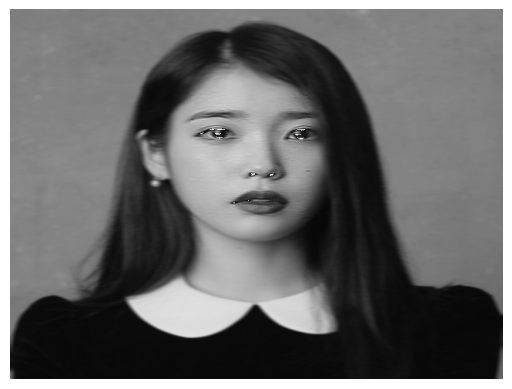

In [17]:
output = np.zeros((246,246), dtype = np.float32)

for (x,y,w,h) in faces:
    face_roi = PS_img[y:y+h, x:x+w]
    
    # kernel for sharpen
    kernel = np.array([[0,-2,0],
                      [-2,9,-2],
                      [0,-2,0]], dtype=np.float32)
    
    padded_face_roi = np.pad(face_roi, ((1,1), (1,1)), mode = 'constant')
    start_time = time.time()
    
    # sharpen convolution
    for a in range(246):
        for b in range(246):
            window = padded_face_roi[a:a+3, b:b+3]
            output[a, b] = np.sum(window*kernel)
    
    # paste the sharpen result on original image
    PS_img[y+40:y+h-40, x+40:x+w-50] = output[0+40:h-40, 0+40:w-50]

end_time = time.time()

processing_time = end_time - start_time
print("PS: ", processing_time, "s")

plt.imshow(PS_img, cmap = 'gray')
plt.axis('off')
plt.show()

## Hardware - Sharpen in PL

In [ ]:
import time

from pynq import allocate
import numpy as np

PL__img = PS_img
input_buffer = allocate(shape=PL_img.shape, dtype=np.uint8)
input_buffer[:] = PL_img
output_buffer = allocate(shape=(PL_img.shape[0]-2, PL_img.shape[1]-2), dtype=np.uint8)
PL_img = np.zeros(shape=PL_img.shape, dtype=np.uint8)

start_time = time.time()

dma_send.sendchannel.transfer(input_buffer)
dma_recv.recvchannel.transfer(output_buffer)

PL_img = np.where(True, output_buffer, output_buffer)
end_time = time.time()

PL_processing_time = end_time - start_time
print("PL: ", PL_processing_time, "s")
accelerate = processing_time/PL_processing_time
print("Acceleration: ", accelerate)


plt.imshow(PL__img, cmap = 'gray')
plt.axis('off')
plt.show()